In [8]:
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
import nltk
import re
import pandas as pd
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from itertools import islice
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kassiewang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kassiewang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [112]:
def text_process(text):
    '''
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Return the cleaned text as a list of words
    4. Remove words
    '''
    stemmer = WordNetLemmatizer()
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join([i for i in nopunc if not i.isdigit()])
    nopunc = [word.lower() for word in nopunc.split()
              if word not in stopwords.words('english')]
    return [stemmer.lemmatize(word) for word in nopunc]

df_clean = pd.read_csv("/Users/kassiewang/GitHub/cds/csv/cleaned.csv")
df_clean = df_clean.dropna()

def nlp(df):
    # lowercase everything
    # get rid of '\n' from whitespace
    # regex remove hyperlinks
    # removing '&gt;'
    # check for emojis
    # remove emojis
    # remove punctuation
    # remove ' s ' from removing punctuation

    # regex remove hyperlinks
    df['cleaned_text'] = df['cleaned_text'].str.replace(
        'http\S+|www.\S+', '', case=False)
    # removing '&gt;'
    df['cleaned_text'] = df['cleaned_text'].apply(
        lambda x: x.replace('&gt;', ''))
    # remove ' s ' that was created after removing punctuations
    df['cleaned_text'] = df['cleaned_text'].apply(
        lambda x: str(x).replace(" s ", " "))
    return df


train_df = nlp(df_clean)
train_comments = train_df['cleaned_text']

In [113]:
vectorizer = TfidfVectorizer(analyzer=text_process,ngram_range=(1,3))
tfidfconvert = vectorizer.fit(train_comments)
X_transformed = tfidfconvert.transform(train_comments)

#len(tfidfconvert.vocabulary_)

In [140]:
from sklearn.cluster import KMeans
modelkmeans = KMeans(n_clusters=8, init='k-means++', n_init=100)
modelkmeans.fit(X_transformed)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=100, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [141]:
def get_key(my_dict, val): 
    for key, value in my_dict.items(): 
         if val == value: 
             return key

def matchvalue(cluster, labels_array, reference):
    clust = np.where(labels_array == cluster)[0]
    df = pd.DataFrame(clust)
    df['word'] = np.nan
    for i in range(df.shape[0]):
        df['word'][i] = get_key(reference, df[0][i])
    return df


In [149]:
np.unique(modelkmeans.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [152]:
final = pd.DataFrame()
final['cluster'] = np.nan
final['words'] = np.nan
final['words'] = final['words'].astype(object)

for i in range(len(np.unique(modelkmeans.labels_))):
    clustnum = np.unique(modelkmeans.labels_)[i]
    final.at[i, 'cluster'] = clustnum
    rawdf = matchvalue(clustnum, modelkmeans.labels_, tfidfconvert.vocabulary_)
    rawlist = list(rawdf['word'].unique())
    final.at[i, 'words'] = rawlist
    
    
#hmm = matchvalue(0, modelkmeans.labels_, tfidfconvert.vocabulary_)
#hmm['word'].unique()

#trying

/Users/kassiewang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/kassiewang/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [153]:
final



,cluster,words
0,0.0,"[abiliy, abrimos, abt, abuse, abusing, accepts..."
1,1.0,"[aau, admiration, admitted, aerospace, afar, a..."
2,2.0,"[abebrown, aca, acccoring, accelerated, accomp..."
3,3.0,"[aaa, aaah, aad, aamin, aampe, aaronchown, aas..."
4,4.0,"[abate, acceptable, accessonline, accidentally..."
5,5.0,"[abhisarsharma, absentee, abused, academicothe..."
6,6.0,"[aaaauto, aapi, abhorrent, abiding, about”, ab..."
7,7.0,"[aampm, aaron, abcinvestigates, abc’s, abend, ..."


In [134]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [138]:
wss = []
K = range(1,10) #range of values of k to try
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_transformed) #X defined from way earlier
    wss.append(km.inertia_)
#     wss.append(sum(np.min(cdist(X, km.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

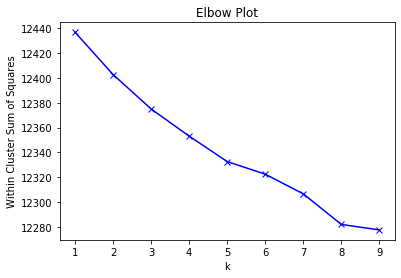

In [139]:
plt.plot(K, wss, 'bx-')
plt.xlabel('k')
plt.ylabel('Within Cluster Sum of Squares')
plt.title('Elbow Plot')
plt.show()